### Goal
- Input: RGB image.
- Teacher: Depth Anything V2 → predicts a high-quality depth map.
- Student: A smaller, faster model → learns to mimic the teacher’s depth map predictions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/subway_surfers_preparation.zip
!pip install -U ray[tune]

In [ ]:
import torch
from torch import nn

import torchvision
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.auto import tqdm
from timeit import default_timer as timer
import random
import ray
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle
import tempfile
from pathlib import Path
from functools import partial

from depth_model.SegNet import SegNet

In [4]:
class DepthDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, depth_maps_dir, transform=None):
        self.images_dir = images_dir
        self.depth_maps_dir = depth_maps_dir
        self.transform = transform

        all_image_files = [f for f in os.listdir(images_dir) if f.lower().endswith('.png')]
        self.files = []
        for image_file in all_image_files:
            depth_file_path = os.path.join(depth_maps_dir, image_file)
            if os.path.exists(depth_file_path):
                self.files.append(image_file)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.files[idx])
        depth_map_path = os.path.join(self.depth_maps_dir, self.files[idx])

        image = plt.imread(image_path)
        depth_map = plt.imread(depth_map_path)[:,:,0]

        if self.transform:
            image = self.transform(image)
            depth_map = self.transform(depth_map)

        return image, depth_map

6258 images and depth maps found in dataset.


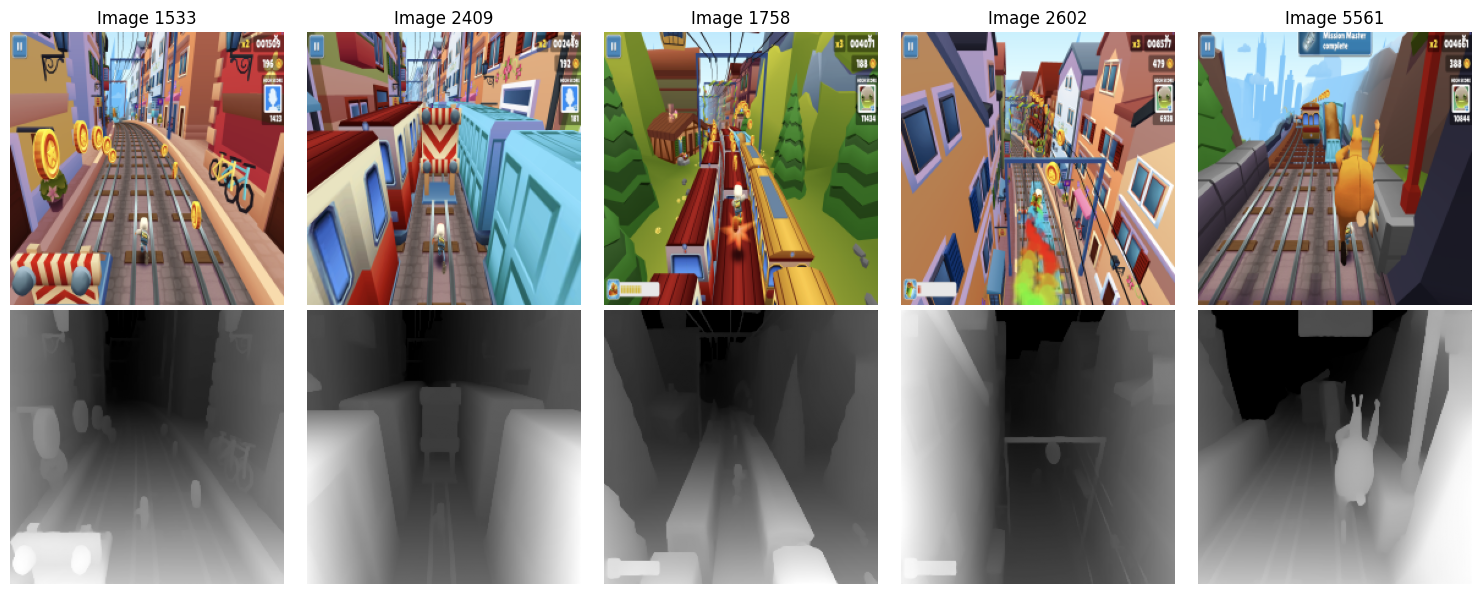

In [5]:
dataset = DepthDataset(
    images_dir='/content/data/depth_data/images',
    depth_maps_dir='/content/data/depth_data/depth_maps',
    transform=ToTensor(),
)

print(dataset.__len__(), "images and depth maps found in dataset.")

# Create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Get 5 random samples from the dataset
indices = np.random.choice(len(dataset), 5, replace=False)

for i, idx in enumerate(indices):
    # Get image and depth map
    image, depth_map = dataset[idx]

    # Convert tensors back to numpy for plotting
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()
    if isinstance(depth_map, torch.Tensor):
        depth_map = depth_map.numpy().squeeze()

    # Plot RGB image in first row
    axes[0, i].imshow(image)
    axes[0, i].set_title(f'Image {idx}')
    axes[0, i].axis('off')

    # Plot depth map in second row
    axes[1, i].imshow(depth_map, cmap='gray')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In [6]:
def train_depth(config):
    net = SegNet(in_channels=3, out_channels=1, features=config["features"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
    net.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])

    checkpoint = get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                checkpoint_state = pickle.load(fp)
            start_epoch = checkpoint_state["epoch"]
            net.load_state_dict(checkpoint_state["net_state_dict"])
            optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    torch.manual_seed(42)
    dataset = DepthDataset(
        images_dir='/content/data/depth_data/images',
        depth_maps_dir='/content/data/depth_data/depth_maps',
        transform=ToTensor(),
    )
    trainset, valset, _ = torch.utils.data.random_split(dataset, [0.7, 0.15, 0.15])
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=config["batch_size"], shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=config["batch_size"], shuffle=False, num_workers=0)

    for epoch in range(start_epoch, 10):
        running_loss = 0.0
        epoch_steps = 0
        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device).float(), y.to(device).float()

            # zero the parameter gradient
            optimizer.zero_grad()

            # forward + backward + optimize
            net.train()
            y_pred = net(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_steps += 1
        if batch % 100 == 99:
            print(
                "[%d, %5d] loss: %.3f"
                % (epoch + 1, batch + 1, running_loss / epoch_steps)
            )
            running_loss = 0.0

        # validation
        val_loss = 0.0
        val_acc = 0.0
        val_steps = 0
        for batch, (X, y) in enumerate(val_loader):
            with torch.inference_mode():
                X, y = X.to(device).float(), y.to(device).float()
                net.eval()
                y_pred = net(X)
                loss = criterion(y_pred, y)
            val_loss += loss.cpu().numpy()
            val_steps += 1
            val_acc += (y_pred.squeeze() - y).abs().mean().item()

        # Report metrics to Ray Tune
        checkpoint_data = {
            "epoch": epoch,
            "net_state_dict": net.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }

        with tempfile.TemporaryDirectory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "wb") as fp:
                pickle.dump(checkpoint_data, fp)

            checkpoint = Checkpoint.from_directory(checkpoint_dir)
            train.report({
                "loss": val_loss / val_steps,
                "accuracy": val_acc / val_steps,
            }, checkpoint=checkpoint)

In [ ]:
# Test the training function directly
config = {"features": 32, "lr": 0.001, "batch_size": 4}
model = train_depth(config)

Epoch 1: val_loss=0.0215, val_acc=0.1422
Epoch 2: val_loss=0.0172, val_acc=0.1389


KeyboardInterrupt: 

In [7]:
def test_accuracy(net):
    torch.manual_seed(42)
    dataset = DepthDataset(
        images_dir='/content/data/depth_data/images',
        depth_maps_dir='/content/data/depth_data/depth_maps',
        transform=ToTensor(),
    )
    _, _, test = torch.utils.data.random_split(dataset, [0.7, 0.15, 0.15])
    test_loader = torch.utils.data.DataLoader(test, batch_size=4, shuffle=False, num_workers=0)

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
    net.to(device)

    test_acc = 0.0
    test_steps = 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_loader):
            X, y = X.to(device).float(), y.to(device).float()
            net.eval()
            y_pred = net(X)
            test_acc += (y_pred.squeeze() - y).abs().mean().item()
            test_steps += 1

    return test_acc / test_steps

In [8]:
def main(num_samples=10, max_num_epochs=10):
    # if not ray.is_initialized():
    #     ray.init(num_cpus=2, num_gpus=1 if torch.cuda.is_available() else 0)

    # config = {
    #     "features": tune.choice([16, 32, 64]),
    #     "lr": tune.loguniform(1e-4, 1e-1),
    #     "batch_size": tune.choice([4, 8, 16, 32])
    # }
    config = {
        "features": 32,
        "lr": 0.001,
        "batch_size": tune.choice([16, 32])
    }

    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2
    )

    result = tune.run(
        train_depth,
        resources_per_trial={
            "cpu": 1,
            "gpu": 0.5,
        },
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        verbose=2,
    )

    best_trial = result.get_best_trial("loss", "min", "last")
    print(f"Best trial config: {best_trial.config}")
    print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
    print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")

    best_trained_model = SegNet(in_channels=3, out_channels=1, features=best_trial.config["features"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    best_trained_model.to(device)

    best_checkpoint = result.get_best_checkpoint(trial=best_trial, metric="accuracy", mode="max")
    with best_checkpoint.as_directory() as checkpoint_dir:
        data_path = Path(checkpoint_dir) / "data.pkl"
        with open(data_path, "rb") as fp:
            best_checkpoint_data = pickle.load(fp)

        best_trained_model.load_state_dict(best_checkpoint_data["net_state_dict"])
        test_acc = test_accuracy(best_trained_model)
        print("Best trial test set accuracy: {}".format(test_acc))

        torch.save({
            'model_state_dict': best_trained_model.state_dict(),
            'config': best_trial.config,
            'test_accuracy': test_acc
        }, 'best_depth_model.pth')


if __name__ == "__main__":
    main(num_samples=2, max_num_epochs=10)

2025-07-29 02:28:05,054	INFO worker.py:1927 -- Started a local Ray instance.
2025-07-29 02:28:07,447	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.


+--------------------------------------------------------------------+
| Configuration for experiment     train_depth_2025-07-29_02-28-07   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 2                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_depth_2025-07-29_02-28-07
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-07-29_02-28-02_472303_26988/artifacts/2025-07-29_02-28-07/train_depth_2025-07-29_02-28-07/driver_artifacts`

Trial status: 2 PENDING
Current time: 2025-07-29 02:28:08. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------+
| Trial name 

(train_depth pid=27474) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_depth_2025-07-29_02-28-07/train_depth_a9b14_00001_1_batch_size=16_2025-07-29_02-28-08/checkpoint_000000)



Trial train_depth_a9b14_00001 finished iteration 1 at 2025-07-29 02:30:26. Total running time: 2min 18s
+--------------------------------------------------------------+
| Trial train_depth_a9b14_00001 result                         |
+--------------------------------------------------------------+
| checkpoint_dir_name                        checkpoint_000000 |
| time_this_iter_s                                   128.27138 |
| time_total_s                                       128.27138 |
| training_iteration                                         1 |
| accuracy                                             0.15303 |
| loss                                     0.02030855230987072 |
+--------------------------------------------------------------+
Trial train_depth_a9b14_00001 saved a checkpoint for iteration 1 at: (local)/root/ray_results/train_depth_2025-07-29_02-28-07/train_depth_a9b14_00001_1_batch_size=16_2025-07-29_02-28-08/checkpoint_000000

Trial train_depth_a9b14_00000 finished i

(train_depth pid=27474) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_depth_2025-07-29_02-28-07/train_depth_a9b14_00001_1_batch_size=16_2025-07-29_02-28-08/checkpoint_000001) [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)



Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2025-07-29 02:31:38. Total running time: 3min 30s
Logical resource usage: 1.0/2 CPUs, 0.5/1 GPUs (0.0/1.0 accelerator_type:T4)
+----------------------------------------------------------------------------------------------------------+
| Trial name                status         batch_size     iter     total time (s)        loss     accuracy |
+----------------------------------------------------------------------------------------------------------+
| train_depth_a9b14_00001   RUNNING                16        2            190.936   0.0157464     0.154328 |
| train_depth_a9b14_00000   TERMINATED             16        1            128.435   0.0220735     0.144311 |
+----------------------------------------------------------------------------------------------------------+
Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2025-07-29 02:32:08. Total running time: 4min 0s
Logical resource usage: 1.0/2 CPUs, 0.5/1 GPUs (0.0/1.0 acceler

(train_depth pid=27474) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_depth_2025-07-29_02-28-07/train_depth_a9b14_00001_1_batch_size=16_2025-07-29_02-28-08/checkpoint_000002)



Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2025-07-29 02:32:38. Total running time: 4min 30s
Logical resource usage: 1.0/2 CPUs, 0.5/1 GPUs (0.0/1.0 accelerator_type:T4)
+----------------------------------------------------------------------------------------------------------+
| Trial name                status         batch_size     iter     total time (s)        loss     accuracy |
+----------------------------------------------------------------------------------------------------------+
| train_depth_a9b14_00001   RUNNING                16        3            252.775   0.0121437     0.151709 |
| train_depth_a9b14_00000   TERMINATED             16        1            128.435   0.0220735     0.144311 |
+----------------------------------------------------------------------------------------------------------+
Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2025-07-29 02:33:08. Total running time: 5min 0s
Logical resource usage: 1.0/2 CPUs, 0.5/1 GPUs (0.0/1.0 acceler

(train_depth pid=27474) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_depth_2025-07-29_02-28-07/train_depth_a9b14_00001_1_batch_size=16_2025-07-29_02-28-08/checkpoint_000003)



Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2025-07-29 02:33:38. Total running time: 5min 31s
Logical resource usage: 1.0/2 CPUs, 0.5/1 GPUs (0.0/1.0 accelerator_type:T4)
+----------------------------------------------------------------------------------------------------------+
| Trial name                status         batch_size     iter     total time (s)        loss     accuracy |
+----------------------------------------------------------------------------------------------------------+
| train_depth_a9b14_00001   RUNNING                16        4            315.133   0.0132678     0.151175 |
| train_depth_a9b14_00000   TERMINATED             16        1            128.435   0.0220735     0.144311 |
+----------------------------------------------------------------------------------------------------------+
Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2025-07-29 02:34:08. Total running time: 6min 1s
Logical resource usage: 1.0/2 CPUs, 0.5/1 GPUs (0.0/1.0 acceler

(train_depth pid=27474) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_depth_2025-07-29_02-28-07/train_depth_a9b14_00001_1_batch_size=16_2025-07-29_02-28-08/checkpoint_000004)



Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2025-07-29 02:34:38. Total running time: 6min 31s
Logical resource usage: 1.0/2 CPUs, 0.5/1 GPUs (0.0/1.0 accelerator_type:T4)
+----------------------------------------------------------------------------------------------------------+
| Trial name                status         batch_size     iter     total time (s)        loss     accuracy |
+----------------------------------------------------------------------------------------------------------+
| train_depth_a9b14_00001   RUNNING                16        5            377.667   0.0107607     0.150029 |
| train_depth_a9b14_00000   TERMINATED             16        1            128.435   0.0220735     0.144311 |
+----------------------------------------------------------------------------------------------------------+
Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2025-07-29 02:35:09. Total running time: 7min 1s
Logical resource usage: 1.0/2 CPUs, 0.5/1 GPUs (0.0/1.0 acceler

(train_depth pid=27474) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_depth_2025-07-29_02-28-07/train_depth_a9b14_00001_1_batch_size=16_2025-07-29_02-28-08/checkpoint_000005)



Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2025-07-29 02:35:39. Total running time: 7min 31s
Logical resource usage: 1.0/2 CPUs, 0.5/1 GPUs (0.0/1.0 accelerator_type:T4)
+----------------------------------------------------------------------------------------------------------+
| Trial name                status         batch_size     iter     total time (s)        loss     accuracy |
+----------------------------------------------------------------------------------------------------------+
| train_depth_a9b14_00001   RUNNING                16        6            439.334   0.0093433     0.156568 |
| train_depth_a9b14_00000   TERMINATED             16        1            128.435   0.0220735     0.144311 |
+----------------------------------------------------------------------------------------------------------+
Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2025-07-29 02:36:09. Total running time: 8min 1s
Logical resource usage: 1.0/2 CPUs, 0.5/1 GPUs (0.0/1.0 acceler

(train_depth pid=27474) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_depth_2025-07-29_02-28-07/train_depth_a9b14_00001_1_batch_size=16_2025-07-29_02-28-08/checkpoint_000006)



Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2025-07-29 02:37:09. Total running time: 9min 1s
Logical resource usage: 1.0/2 CPUs, 0.5/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------+
| Trial name                status         batch_size     iter     total time (s)         loss     accuracy |
+-----------------------------------------------------------------------------------------------------------+
| train_depth_a9b14_00001   RUNNING                16        7            501.862   0.00883196     0.159401 |
| train_depth_a9b14_00000   TERMINATED             16        1            128.435   0.0220735      0.144311 |
+-----------------------------------------------------------------------------------------------------------+
Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2025-07-29 02:37:39. Total running time: 9min 31s
Logical resource usage: 1.0/2 CPUs, 0.5/1 GPUs (0.0/1.0 a

(train_depth pid=27474) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_depth_2025-07-29_02-28-07/train_depth_a9b14_00001_1_batch_size=16_2025-07-29_02-28-08/checkpoint_000007)



Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2025-07-29 02:38:09. Total running time: 10min 1s
Logical resource usage: 1.0/2 CPUs, 0.5/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------+
| Trial name                status         batch_size     iter     total time (s)         loss     accuracy |
+-----------------------------------------------------------------------------------------------------------+
| train_depth_a9b14_00001   RUNNING                16        8            563.974   0.00863742     0.153453 |
| train_depth_a9b14_00000   TERMINATED             16        1            128.435   0.0220735      0.144311 |
+-----------------------------------------------------------------------------------------------------------+
Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2025-07-29 02:38:39. Total running time: 10min 31s
Logical resource usage: 1.0/2 CPUs, 0.5/1 GPUs (0.0/1.0

(train_depth pid=27474) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_depth_2025-07-29_02-28-07/train_depth_a9b14_00001_1_batch_size=16_2025-07-29_02-28-08/checkpoint_000008)



Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2025-07-29 02:39:09. Total running time: 11min 1s
Logical resource usage: 1.0/2 CPUs, 0.5/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------+
| Trial name                status         batch_size     iter     total time (s)         loss     accuracy |
+-----------------------------------------------------------------------------------------------------------+
| train_depth_a9b14_00001   RUNNING                16        9            625.675   0.00796709     0.155611 |
| train_depth_a9b14_00000   TERMINATED             16        1            128.435   0.0220735      0.144311 |
+-----------------------------------------------------------------------------------------------------------+
Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2025-07-29 02:39:39. Total running time: 11min 31s
Logical resource usage: 1.0/2 CPUs, 0.5/1 GPUs (0.0/1.0

2025-07-29 02:39:46,387	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_depth_2025-07-29_02-28-07' in 0.0329s.



Trial train_depth_a9b14_00001 finished iteration 10 at 2025-07-29 02:39:46. Total running time: 11min 38s
+--------------------------------------------------------------+
| Trial train_depth_a9b14_00001 result                         |
+--------------------------------------------------------------+
| checkpoint_dir_name                        checkpoint_000009 |
| time_this_iter_s                                    62.69633 |
| time_total_s                                       688.37098 |
| training_iteration                                        10 |
| accuracy                                             0.15816 |
| loss                                     0.00870156567543745 |
+--------------------------------------------------------------+
Trial train_depth_a9b14_00001 saved a checkpoint for iteration 10 at: (local)/root/ray_results/train_depth_2025-07-29_02-28-07/train_depth_a9b14_00001_1_batch_size=16_2025-07-29_02-28-08/checkpoint_000009

Trial train_depth_a9b14_00001 complet

(train_depth pid=27474) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_depth_2025-07-29_02-28-07/train_depth_a9b14_00001_1_batch_size=16_2025-07-29_02-28-08/checkpoint_000009)


Best trial test set accuracy: 0.13982916512387863


Sorce: https://arxiv.org/pdf/1406.2283

In [9]:
def make_predictions(
    model: torch.nn.Module,
    data: list,
    device: torch.device = "cpu"
):
    model.to(device)
    model.eval()
    predictions = []
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred = model(sample)
            pred = pred.squeeze()
            predictions.append(pred)

    return predictions

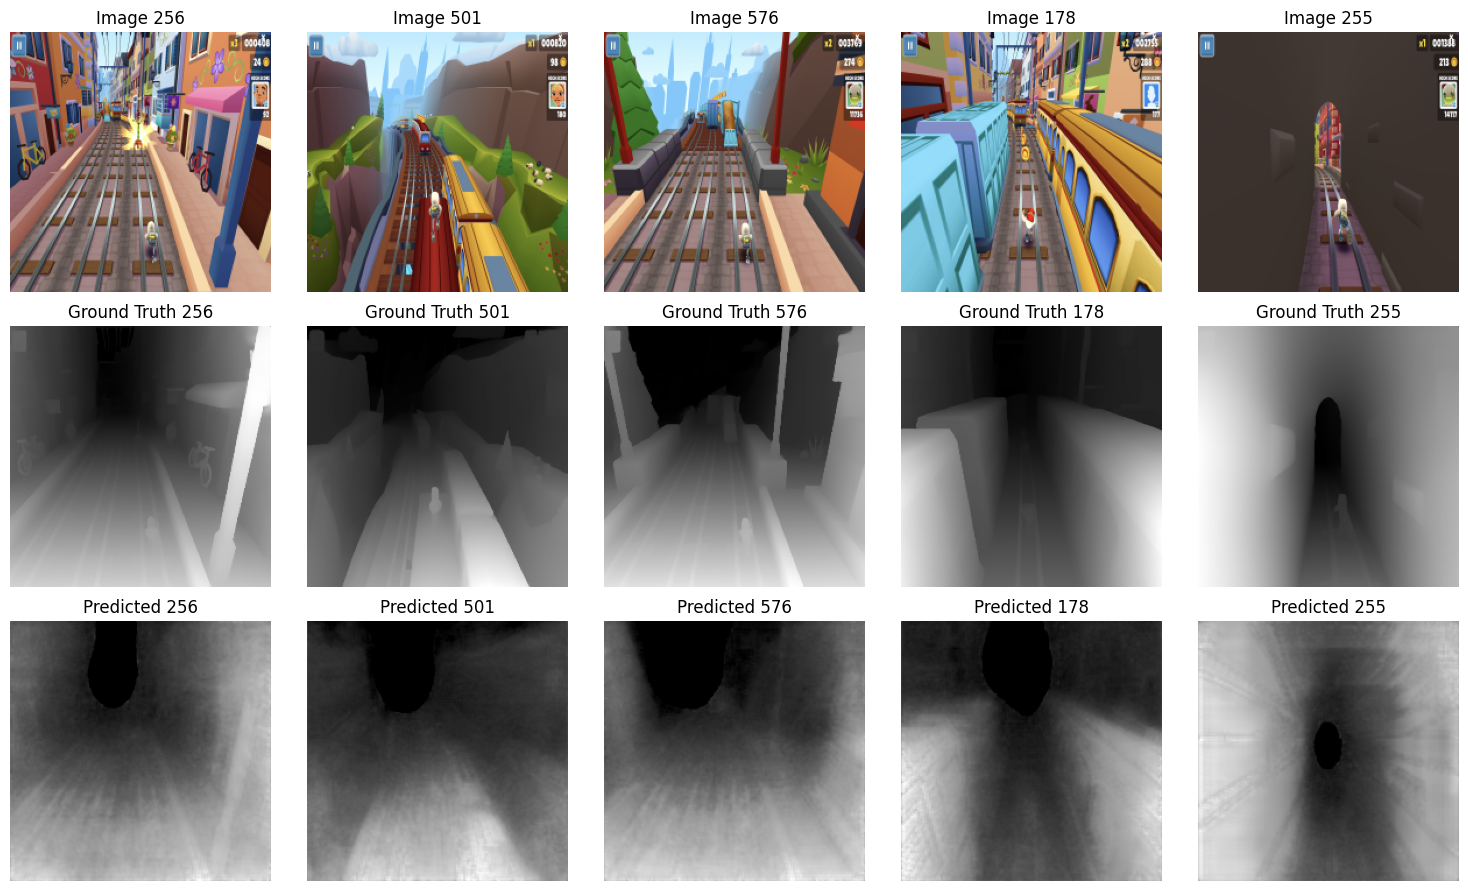

In [11]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"

checkpoint = torch.load('best_depth_model.pth')
model = SegNet(
    in_channels=3,
    out_channels=1,
    features=checkpoint['config']['features']
)
model.load_state_dict(checkpoint['model_state_dict'])

_, _, testset = torch.utils.data.random_split(dataset, [0.7, 0.15, 0.15])
samples = random.sample(range(len(testset)), 5)
predictions = make_predictions(model, [testset[i][0] for i in samples], device=device)

# Show original image, ground truth depth, and predicted depth
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for i, idx in enumerate(samples):
    image, depth_map = testset[idx]
    pred = predictions[i].cpu().numpy()

    # Convert tensors back to numpy for plotting
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()
    if isinstance(depth_map, torch.Tensor):
        depth_map = depth_map.numpy().squeeze()

    # Row 1: Original images
    axes[0, i].imshow(image)
    axes[0, i].set_title(f'Image {idx}')
    axes[0, i].axis('off')

    # Row 2: Ground truth depth maps
    axes[1, i].imshow(depth_map, cmap='gray')
    axes[1, i].set_title(f'Ground Truth {idx}')
    axes[1, i].axis('off')

    # Row 3: Predicted depth maps
    axes[2, i].imshow(pred, cmap='gray')
    axes[2, i].set_title(f'Predicted {idx}')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()